In [2]:
# Extract correct dataset
from zipfile import ZipFile

abst = ZipFile('abstracts.zip')

for file in abst.namelist():
    if file.startswith('abstracts/awards_2002/'):
        abst.extract(file)


In [2]:
# Extracts abstracts from documents
import os

rootdir = 'abstracts/awards_2002'
documents = []

for sdir, dirs, files in os.walk(rootdir):
    for file in files:
        with open(os.path.join(sdir,file), "rt", encoding="unicode_escape") as f:
            documents.append([line.strip() for line in f.readlines()])
            
abstracts = []
for d in documents:
    s = ""
    for i, t in enumerate(d):
        if "Abstract" in t:
            for t in d[i+1:]:
                s += f" {t}"
                
    abstracts.append(s)


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Set parameters and initialize
tfidf_vectorizer = TfidfVectorizer(min_df=2, use_idf=True, sublinear_tf=True, max_df=0.8, max_features=50000)

# Calcualate term-document matrix with tf-idf scores
tfidf_matrix = tfidf_vectorizer.fit_transform(abstracts)

# Check matrix shape
tfidf_matrix.toarray().shape # N_docs x N_terms


(9923, 27299)

In [4]:
print(tfidf_vectorizer.get_feature_names()[:10])
print(tfidf_vectorizer.get_feature_names()[-10:])


['00', '000', '0000', '0001', '000l', '001', '002', '003', '0085834', '01']
['zorin', 'zr', 'zro2', 'zuni', 'zurich', 'zworski', 'zygmund', 'zygomycetes', 'zygomycota', 'zygotic']


In [5]:
tfidf_matrix[:,tfidf_vectorizer.get_feature_names().index('record')].toarray() # Get doc vector for term


array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [6]:
from collections import Counter
terms_in_docs = tfidf_vectorizer.inverse_transform(tfidf_matrix)
token_counter = Counter()
for terms in terms_in_docs:
    token_counter.update(terms)

for term, count in token_counter.most_common(20):
    print("%d\t%s" % (count, term))


7632	be
7419	on
7271	with
7167	that
6656	are
6642	research
6561	by
6424	as
5968	from
5750	an
5402	these
5401	project
5365	at
4294	have
4108	which
3958	new
3739	or
3727	it
3669	their
3617	has


In [7]:
features = tfidf_vectorizer.get_feature_names()
for doc_i in range(5):
    print("\nDocument %d, top terms by TF-IDF" % doc_i)
    for term, score in sorted(list(zip(features,tfidf_matrix.toarray()[doc_i])), key=lambda x:-x[1])[:5]:
        print("%.2f\t%s" % (score, term))



Document 0, top terms by TF-IDF
0.29	chow
0.19	hodge
0.19	algebraic
0.14	geometry
0.14	subgroup

Document 1, top terms by TF-IDF
0.24	friendships
0.22	cultivating
0.21	ethnically
0.20	control
0.20	exchanging

Document 2, top terms by TF-IDF
0.24	updating
0.17	reference
0.17	secondly
0.15	damped
0.14	vibrating

Document 3, top terms by TF-IDF
0.24	conference
0.20	computations
0.20	learn
0.18	theory
0.18	group

Document 4, top terms by TF-IDF
0.21	uncontrollable
0.20	commonality
0.19	uncertainties
0.18	preferences
0.18	alternative


In [8]:
print(tfidf_matrix.toarray())


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [9]:
print("Document vector length:", tfidf_matrix.shape[1])
for i in range(5):
    print("Non-zero dimensions for document %d: %d" % (i, len([x for x in tfidf_matrix.toarray()[i] if x > 0])))


Document vector length: 27299
Non-zero dimensions for document 0: 202
Non-zero dimensions for document 1: 67
Non-zero dimensions for document 2: 131
Non-zero dimensions for document 3: 97
Non-zero dimensions for document 4: 142


In [10]:
print("Sample word:", features[1000])
print("Occurs in %d documents" % len([x for x in tfidf_matrix.toarray()[:][1000] if x > 0]))
print("out of %d documents" % len(tfidf_matrix.toarray()))


Sample word: activate
Occurs in 110 documents
out of 9923 documents


In [11]:
matrix_sample = tfidf_matrix[:1000]
from sklearn.cluster import KMeans

# Do clustering
km = KMeans(n_clusters=30, random_state=123, verbose=0)
km.fit(matrix_sample)


KMeans(n_clusters=30, random_state=123)

In [12]:
import heapq, numpy as np

# Custom function to print top keywords for each cluster
def print_clusters(matrix, clusters, n_keywords=10):
    for cluster in range(min(clusters), max(clusters)+1):
        cluster_docs = [i for i, c in enumerate(clusters) if c == cluster]
        print("Cluster: %d (%d docs)" % (cluster, len(cluster_docs)))
        
        # Keep scores for top n terms
        new_matrix = np.zeros((len(cluster_docs), matrix.shape[1]))
        for cluster_i, doc_vec in enumerate(matrix[cluster_docs].toarray()):
            for idx, score in heapq.nlargest(n_keywords, enumerate(doc_vec), key=lambda x:x[1]):
                new_matrix[cluster_i][idx] = score

        # Aggregate scores for kept top terms
        keywords = heapq.nlargest(n_keywords, zip(new_matrix.sum(axis=0), features))
        print(', '.join([w for s,w in keywords]))
        print()


In [13]:
km.labels_


array([22,  9,  1,  9, 28, 22, 15,  6, 27,  1, 12, 15,  8,  6,  9, 10,  7,
        5,  1, 27, 20,  8, 20, 20, 12, 20, 10, 22,  1, 14, 12, 20,  6, 12,
       12, 14,  6,  7,  6,  6, 26, 26, 20, 10, 20, 12, 22, 12,  1, 22,  6,
       20,  7, 11, 29, 14, 12,  6, 10, 26, 22, 28, 11, 14, 26,  7, 12, 20,
       22, 12,  8, 14,  8, 11,  7,  8, 28,  8,  5,  8, 11, 12, 11, 14,  7,
       10,  5, 10, 20, 10, 28, 10, 11, 10, 12,  1, 20, 12, 26,  1,  1, 12,
       10, 14, 14,  6, 15,  6, 22, 14, 26, 20,  9, 22, 20, 16, 20,  9,  1,
       29, 20,  8,  8, 12, 10, 20,  8, 29, 12, 20,  4, 12,  7, 15, 11, 27,
       22, 10, 12,  7, 14,  7,  7, 15, 26, 12, 11, 26, 11,  7, 12, 16, 22,
        5, 20, 13,  6,  5, 26, 22,  6, 22,  6, 26, 26, 12,  8, 22, 11,  7,
       26,  7,  7,  7, 12,  7,  7, 15, 20, 20, 26, 26,  6, 22, 26, 22, 15,
       11, 14,  1, 16,  6,  7,  7, 26,  4, 16, 15, 26,  7, 11,  8,  7, 12,
        9, 16, 15, 26, 15, 14, 27,  1,  6, 15, 27,  8,  8, 15, 12, 23,  6,
       26,  6,  8, 16,  6

In [14]:
print_clusters(matrix_sample, km.labels_)


Cluster: 0 (11 docs)
china, urban, town, metropolitan, tourism, qing, modernity, beirut, landscape, verde

Cluster: 1 (35 docs)
printing, resistivity, regression, xerography, sequential, sinkholes, statistical, uml, markov, industry

Cluster: 2 (85 docs)
teachers, colleges, college, curriculum, teacher, alliance, workforce, technicians, manufacturing, industry

Cluster: 3 (16 docs)
fellowship, postdoctoral, he, informatics, redshift, galaxies, training, she, stars, astronomy

Cluster: 4 (24 docs)
straightening, repair, regression, nigms, anthracis, heat, bacillus, linear, damaged, error

Cluster: 5 (28 docs)
curvature, manifolds, metrics, einstein, riemannian, conformal, jets, kona, transverse, lows

Cluster: 6 (49 docs)
equations, dynamical, schrodinger, nonlinear, approximation, resonances, asymptotic, waves, maps, fluid

Cluster: 7 (43 docs)
operators, harmonic, ergodic, operator, theorems, integrals, equations, spaces, toeplitz, polynomial

Cluster: 8 (48 docs)
polymer, films, diam

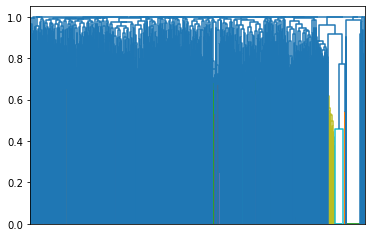

In [15]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

Z = linkage(matrix_sample.todense(), metric='cosine', method='complete')
_ = dendrogram(Z, no_labels=True) # Plot dentrogram chart


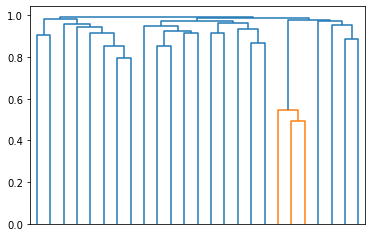

In [16]:
Z_ = linkage(matrix_sample.todense()[:25], metric='cosine', method='complete')
_ = dendrogram(Z_, no_labels=True) # Plot dentrogram chart


In [17]:
clusters = fcluster(Z, 0.99, criterion='distance') # Create flat clusters by distance threshold

print_clusters(matrix_sample, clusters)


Cluster: 1 (7 docs)
ethnic, tourism, chinese, workers, tourist, firms, guides, tour, welfare, beirut

Cluster: 2 (5 docs)
costa, subduction, arc, mantle, passcal, flux, rica, factory, wedge, receiver

Cluster: 3 (4 docs)
tectonically, continental, gulf, detachment, earlist, dredge, segmented, rifts, basement, accompanies

Cluster: 4 (13 docs)
magnetic, magnetosphere, ionosphere, inner, ring, particle, formalism, auroral, relativistic, ions

Cluster: 5 (7 docs)
aerosol, muon, indoex, rsvp, climate, ice, chile, rainy, ring, logger

Cluster: 6 (8 docs)
iron, arsenic, sediment, corrosion, haiwee, phosphorus, strickland, floodplain, sediments, srb

Cluster: 7 (56 docs)
customer, china, cad, nonlinear, control, platform, land, platforms, reverse, planning

Cluster: 8 (29 docs)
sdp, wavelet, polynomials, semidefinite, speckle, quadratic, integer, convex, dynamical, wavelets

Cluster: 9 (62 docs)
quantum, superconductors, magnetic, spin, superconductivity, composite, superconducting, frp, supe

In [18]:
## Topic modeling demo
#!pip3 install gensim

# Fast and simple tokenization
new_vectorizer = TfidfVectorizer()
word_tokenizer = new_vectorizer.build_tokenizer()
tokenized_text = [word_tokenizer(doc) for doc in abstracts]

# Train LDA model
from gensim import corpora, models
dictionary = corpora.Dictionary(tokenized_text)
lda_corpus = [dictionary.doc2bow(text) for text in tokenized_text]
lda_model = models.LdaModel(lda_corpus, id2word=dictionary, num_topics=10)


In [19]:
from sklearn.metrics.pairwise import cosine_similarity

term_index = 1000
print("Similar terms to:", features[term_index])
# Get most similar terms according to the cosine similarity of their vectors (columns in the term-document matrix)
heapq.nlargest(10, zip(cosine_similarity(tfidf_matrix[:,term_index].todense().T, tfidf_matrix.todense().T)[0], features))


Similar terms to: activate


[(1.0, 'activate'),
 (0.4467520998979391, 'coactivators'),
 (0.42889032702581664, 'progesterone'),
 (0.32482802354394924, 'src'),
 (0.2686122567729347, 'glucan'),
 (0.2497143994273816, 'ovarian'),
 (0.23081499344794168, 'actin'),
 (0.22417103095601956, 'p53'),
 (0.20983754293502693, 'immuno'),
 (0.20794789527290336, 'steroid')]

In [20]:
import gensim # Make sure you also have cython installed to accelerate computation!

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Train word2vec model
vectors = gensim.models.Word2Vec(tokenized_text, size=100, window=5, min_count=3, workers=4)


2021-02-24 10:41:47,280 : INFO : collecting all words and their counts
2021-02-24 10:41:47,281 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-02-24 10:41:47,780 : INFO : collected 63620 word types from a corpus of 2817564 raw words and 9923 sentences
2021-02-24 10:41:47,781 : INFO : Loading a fresh vocabulary
2021-02-24 10:41:47,957 : INFO : effective_min_count=3 retains 29581 unique words (46% of original 63620, drops 34039)
2021-02-24 10:41:47,958 : INFO : effective_min_count=3 leaves 2774058 word corpus (98% of original 2817564, drops 43506)
2021-02-24 10:41:48,052 : INFO : deleting the raw counts dictionary of 63620 items
2021-02-24 10:41:48,054 : INFO : sample=0.001 downsamples 26 most-common words
2021-02-24 10:41:48,054 : INFO : downsampling leaves estimated 2161148 word corpus (77.9% of prior 2774058)
2021-02-24 10:41:48,125 : INFO : estimated required memory for 29581 words and 100 dimensions: 38455300 bytes
2021-02-24 10:41:48,126 : INFO : res

In [21]:
# Inspect a word vector
vectors.wv['process']


array([-0.90953004,  0.81836754, -1.2900009 ,  1.1606756 ,  1.4592584 ,
        0.54667056,  1.7854558 ,  0.92765826,  1.3956335 , -0.177849  ,
        0.09046485, -1.6987875 ,  1.357826  , -0.11927579, -0.014988  ,
        0.23494846, -0.19581324,  0.7204914 ,  0.64068794, -3.3971977 ,
        0.3191342 ,  1.3723253 , -0.9613194 , -0.54091525, -0.9888401 ,
        1.1723601 , -0.07445102, -0.799723  ,  0.07201891, -0.05726195,
        0.45764053, -0.19950882,  0.43562016, -1.721234  , -0.23484747,
       -0.876995  , -0.5557397 ,  0.04679805, -1.5417254 ,  0.16043055,
       -1.5130715 ,  0.7550467 , -0.49763212,  0.7748843 ,  0.01341338,
        1.4457353 , -1.7432455 ,  1.0071301 ,  1.8084767 , -0.37255585,
       -1.2984295 , -0.05650708,  1.1424354 , -0.6647455 ,  1.8810067 ,
       -0.8860951 ,  0.37330547,  0.2339391 ,  0.16134171, -0.04955637,
       -0.1414454 , -1.6622316 ,  0.43541706, -2.6808136 , -0.05063106,
        0.00950527,  0.81399316,  1.1374755 ,  0.49267164, -1.72

In [22]:
# Inspect words with vectors most similar to a given word
print("Most similar to:", 'process')
print(vectors.wv.most_similar('process'))
print()


2021-02-24 10:42:00,591 : INFO : precomputing L2-norms of word weight vectors


Most similar to: process
[('strategy', 0.7257898449897766), ('mechanism', 0.6809995770454407), ('product', 0.6792237758636475), ('architecture', 0.6622252464294434), ('manner', 0.6400573253631592), ('way', 0.6343898773193359), ('paradigm', 0.6276974678039551), ('activity', 0.6218494176864624), ('formulation', 0.6190251708030701), ('system', 0.6143497228622437)]



In [23]:
# ...or combination or words (average vector)
print("Most similar to:", ['process', 'strategy'])
print(vectors.wv.most_similar(['process', 'strategy']))


Most similar to: ['process', 'strategy']
[('paradigm', 0.7559958100318909), ('approach', 0.740641176700592), ('methodology', 0.7338005304336548), ('architecture', 0.7316803336143494), ('product', 0.7177249193191528), ('protocol', 0.698704719543457), ('way', 0.6967167854309082), ('formulation', 0.69472336769104), ('mechanism', 0.6942002773284912), ('tool', 0.6924450397491455)]


In [24]:
# Inspect cosine similarities between specific words
print(vectors.wv.similarity('technology', 'infrastructure'))
print(vectors.wv.similarity('technology', 'system'))
print(vectors.wv.similarity('technology', 'consumer'))
print(vectors.wv.similarity('technology', 'advanced'))


0.5949236
0.3743288
0.3559913
0.5727541


In [28]:
words = [list(vectors.wv.vocab.keys())[(i+1)*1200] for i in range(5)]
print(words)

['exacerbate', 'interface', 'fire', 'pathways', 'fewer']


In [29]:
print(vectors.wv.most_similar(words[0]))
print(vectors.wv.most_similar(words[1]))
print(vectors.wv.most_similar(words[2]))
print(vectors.wv.most_similar(words[3]))
print(vectors.wv.most_similar(words[4]))



[('Jewish', 0.8873485326766968), ('sects', 0.8749203681945801), ('stop', 0.8700597286224365), ('tan', 0.8687407970428467), ('maliciously', 0.8622428178787231), ('Has', 0.860679030418396), ('domestically', 0.8603434562683105), ('owners', 0.8577088117599487), ('favors', 0.8572164177894592), ('overly', 0.8551536798477173)]
[('interfaces', 0.8546984791755676), ('nanoscale', 0.6302165985107422), ('layer', 0.6252212524414062), ('coupling', 0.618942141532898), ('circuit', 0.6170817613601685), ('architecture', 0.6104079484939575), ('interaction', 0.6074636578559875), ('continuum', 0.6067649126052856), ('switch', 0.5920110940933228), ('link', 0.5891084671020508)]
[('vegetation', 0.8950409293174744), ('seasonal', 0.8772874474525452), ('forest', 0.8685150146484375), ('climatic', 0.8591132164001465), ('climates', 0.838323712348938), ('dispersal', 0.8271552920341492), ('floodplain', 0.8205798864364624), ('flood', 0.8170578479766846), ('interannual', 0.8142204284667969), ('arctic', 0.808866739273071